In this file we have used the reward function as the account balance increase and decrease taken into account

the reward function should be a mathematical curve to explain to the model what essentially it should do

In [1]:
import matplotlib.pyplot as plt
import random, shutil, pickle, sys
import numpy as np
from collections import deque
from keras import Sequential
# from keras.optimizers import RMSprop
from IPython.display import display
from PIL import Image
import pandas as pd
from keras import Model
import keras, os, glob
import tensorflow as tf
from keras.layers import Layer, Dense, Flatten, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from keras.layers import Activation, Bidirectional , Dropout
from keras import layers
# import cv2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import codecs
import csv
import secrets
import sqlite3
from IPython.display import display
from IPython.display import clear_output
import time
from tabulate import tabulate
import json
import datetime
from tensorflow.keras.optimizers import Adam

In [2]:
class ChartDecorator:
    def __init__(self):
        self.balance_limit = 300
        self.standard_balance = 1000
        self.prev_trade = None
        
    def add_top_bottom_bar(self, img, draw_context):
        # Define the coordinates of the black bar
        x1, y1 = 0, 204
        x2, y2 = 200, 224
        # Draw the black bar bottom bar
        draw_context.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))
        # Draw the black bar top bar
        x1, y1 = 0, 0
        x2, y2 = 224, 14
        draw_context.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))


    def draw_account_balance(self, img, draw_context, account_balance = 1000):
        balance = self.balance_limit + (account_balance - self.standard_balance)
        if balance == self.balance_limit:
            x1, y1 = 3, 204
            x2, y2 = 75 , 224
            # Draw the green bar for account
            draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131))

        elif balance < self.balance_limit:
            health_bar = int((balance * 75) / self.balance_limit )
            lost_bar = 75 - health_bar
            #issue 1
            # print(f"issue 1 balance {balance}")
            # print(f"health bar {health_bar}")
            
            # print(f"lost bar {lost_bar}")
            #current_balnace
            x1, y1 = 3, 204
            x2, y2 = health_bar, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131))
            #lost bar
            x1, y1 = health_bar, 204
            x2, y2 = 75 , 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 0, 0))
        elif balance > self.balance_limit:
            x1, y1 = 3, 204
            x2, y2 = 75 , 224
            # Draw the green bar for account
            draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131)) 
            #Draw the profit section on account_bar
            profit = int(((balance - self.balance_limit) * 75) / self.balance_limit)

            x1, y1 = 80, 204
            x2, y2 = 80 + profit , 224
            # Draw the green bar for account
            draw_context.rectangle([x1, y1, x2, y2], fill=(0,0,255))# fill=(71, 44, 27)) 

        #draw start separator
        #draw Account Separator and end separator
        x1, y1 = 0, 204
        x2, y2 = 3 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20))     

        #draw Account Separator and end separator
        x1, y1 = 76, 204
        x2, y2 = 80 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20)) 

        #draw Account Separator and end separator
        x1, y1 = 155, 204
        x2, y2 = 160 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20)) 

    def draw_current_trade(self,img, draw_context, position=None):
        if position == "buy":
            x1, y1 = 160, 204
            x2, y2 = 175, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 0)) 
        elif position == "sell":
            x1, y1 = 180, 204
            x2, y2 = 195, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(0, 255, 0))  
        else:
            x1, y1 = 200, 204
            x2, y2 = 215, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(255,0,255)) 

        #Draw position separator icons
        x1, y1 = 175, 204
        x2, y2 = 180, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
        x1, y1 = 195, 204
        x2, y2 = 200, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
        x1, y1 = 215, 204
        x2, y2 = 220, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 

    def draw_profit_bar(self, img, draw_context, profit = 0, account_balance = 1000, position = None):
        pnl_parts = int(abs(profit) / 10)
        for segment in range(0, 200, 10):
            f = segment + 10
            x1, y1 = segment+10, 0
            x2, y2 = f + 1, 9
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
            #display profit on the chart
            if profit > 0 and pnl_parts > 0 and segment >= 100:
                if segment < pnl_parts * 10 + 100:
                    x1, y1 = segment, 0
                    x2, y2 = segment + 10, 9
                    draw_context.rectangle([x1, y1, x2, y2], fill=(27, 152, 224)) 
            elif profit < 0 and pnl_parts > 0 and segment <= 90 and segment >= 100 - abs(profit):           
                x1, y1 = segment, 0
                x2, y2 = segment + 10, 9
                draw_context.rectangle([x1, y1, x2, y2], fill=(255, 0, 0))  
            #draw progressive account balance below profit bar
            account_balance_bar = (200*account_balance)/2000
            x1, y1 = 0, 10
            x2, y2 = account_balance_bar, 14
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 119, 0)) 
            #Add a closing indication at the top of the 
            if position == "close" and profit > 0 and self.prev_trade[2] == 1:
                x1, y1 = 200, 0
                x2, y2 = 224, 14
                draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 0))
            elif position == "close" and profit > 0 and self.prev_trade == 2:
                x1, y1 = 200, 0
                x2, y2 = 224, 14
                draw_context.rectangle([x1, y1, x2, y2], fill=(0, 255, 0))
            elif position == "close" and profit < 0 and self.prev_trade in [2,1]:
                x1, y1 = 200, 0
                x2, y2 = 224, 14
                draw_context.rectangle([x1, y1, x2, y2], fill=(255,0, 0))
       
    def draw_buy_bar(self, img2, start_lines, end_lines, position = None, profit = 0, prev_trade=None, account_balance = 1100 ):
        self.prev_trade = prev_trade
        
        from PIL import Image, ImageDraw
        d = ImageDraw.Draw(img2)
        
        self.add_top_bottom_bar(img2, d)
        self.draw_account_balance(img2, d, account_balance)

        if position == "sell" and 2 in [self.prev_trade[3]]:
            #draw icon for trade setup
            self.draw_current_trade(img2, d, "sell")
            fixed_ratio = False
            #issue fix bug 
            #a situation where there is profit but since the trade was entered there were pertuabations of zooming and changing of window prices indicated on the subwindow
            #fix this by giving a ratio use profit to check if we are profitable, then check if end lines are lower than start lines , use a ratio of 1px for 3 points
            #when scaling the bar check the distance remaining behind you at the top of the window. start from index 14 your calculations
            if profit >= 0 and start_lines["ask_line"] > end_lines["ask_line"] :
                # print(f"\nRatio bug found {end_lines}\n")
                ratio = 15 #int((start_lines["ask_line"] - end_lines["ask_line"] ) / 3)
                if end_lines["ask_line"] - ratio < 14:
                    start_lines["ask_line"] = 14
                    start_lines["bid_line"] = 18
                else:
                    start_lines["ask_line"] = end_lines["ask_line"] - ratio
                    start_lines["bid_line"] = end_lines["bid_line"] - ratio
                fixed_ratio = True

            # Draw indicator of trade start
            
            line_color = (200,200,200)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=20)

            #Draw start marker for the trade
            line_color = (0, 255, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30) 
            
            #Draw start line for trade entry
            line_color = (0, 255, 0)#(252, 81, 48)
            top = (50, start_lines["ask_line"])
            bottom = (50, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=250) 

            #Draw profit indicator of sell
            if profit < 0:
                #Draw the main bar of the trade position
                if fixed_ratio:
                    line_color = (255, int(ratio/2+10), 0)
                    top = (200, start_lines["ask_line"])
                    bottom = (200,end_lines["bid_line"])
                    d.line([top, bottom], fill=line_color, width=int(ration/5)+10)
                    fixed_ratio = False
                else:
                    line_color = (255, 0, 0)
                    top = (200, start_lines["ask_line"])
                    bottom = (200,end_lines["bid_line"])
                    d.line([top, bottom], fill=line_color, width=10)
                
            else:
                line_color = (0, 255, 0)
                top = (200, start_lines["ask_line"])
                bottom = (200,end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)
            #Draw loss indicator for sell
            self.draw_profit_bar(img2, d, profit)
        elif position == "buy" and 1 in [self.prev_trade[3]]:
            #issue fix bug 2
            if profit >= 0 and end_lines["ask_line"] > start_lines["ask_line"]:
                ratio = 15
                if end_lines["bid_line"] + ratio > 204:
                    start_lines["ask_line"] = 200
                    start_lines["bid_line"] = 204
                else:
                    start_lines["ask_line"] = end_lines["ask_line"] + ratio
                    start_lines["bid_line"] = end_lines["bid_line"] + ratio         
            
            #draw bottom right trade status sell , buy , close
            self.draw_current_trade(img2, d, "buy") # 
            #Draw indicator of trade start
            #Draw end marker
            line_color = (65, 64, 102)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=20) 

            #Draw start marker for buy
            line_color = (255, 255, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30) 

            #Draw start buy line across the chart
            line_color = (255, 255, 0)#(255,0,200)
            top = (50, start_lines["ask_line"])
            bottom = (50, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=250)         


            if profit < 0:
                line_color = (255, 0, 0)
                top = (200, start_lines["ask_line"])
                bottom = (200, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)
            else:
                line_color = (255, 255, 0)
                top = (200, start_lines["ask_line"])
                bottom = (200, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)

            self.draw_profit_bar(img2, d, profit)


        elif position in ["buy", "sell"] and self.prev_trade[3] == 0:
            # print(f"Draw buy bar \n\nElse{position}\n\n:")
            #draw main vertical bar
            self.draw_current_trade(img2, d, "close")

            line_color = (255,0,255)
            top = (200, start_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=15)
            #draw end bar
            line_color = (255,0,255)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30) 
            #Draw start marker and line
            line_color = (255,0,255)
            top = (200, start_lines["ask_line"])
            bottom = (200, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30)

            line_color = (2, 8, 135)
            top = (50, start_lines["ask_line"])
            bottom = (50, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=250)

            # self.draw_profit_bar(img2, d, profit)

            if self.prev_trade[2] == 2 and profit > 0:   
                #print right bar for the trade that has closed
                line_color = (0, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (241, 254, 198)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)             

            elif self.prev_trade[2] == 2 and profit < 0:
                line_color = (0, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (255,0,0)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)    
            elif self.prev_trade[2] == 1 and profit > 0:
                # print(f"\n\nHey I was here\n\n{self.prev_trade}")
                
                line_color = (255, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (241, 254, 198)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)    

            elif self.prev_trade[2] == 1 and profit < 0:
                line_color = (255, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (255,0,0)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 
        else :#:position == "close" and self.prev_trade[2] == 0:
            self.draw_current_trade(img2, d, "close")
            # print("I run for position Close")
            line_color = (255,0,255)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30)  

        self.draw_profit_bar(img2, d, profit, account_balance, position)

        return img2

In [3]:
# def display_row_images(long_short_dict_now , long_short_dict_next):
from collections import deque
class ForexCustomEnv:
    def __init__(self, m1short, m5short,chart_decorator):
        self.m1short = m1short
        self.m5short = m5short
        self.trade_queue = deque(maxlen=4)
        self.image_queue = deque(maxlen=4)
        self.trade_queue_m5 = deque(maxlen=4)
        self.image_queue_m5 = deque(maxlen=4)
        self.dataset_directory = "colabM1M5/episode2/"
        self.account_balance = 1000
        self.env_draw = False
        self.chart_decorator = chart_decorator
        
        self.prev_trade = deque(maxlen=4)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        
        self.current_step = 4
        self.action = 0
        self.position = "close"

    def get_ask_bid_lines(self, image_path):
        ask_bid_lines = {"ask_line":None, "bid_line":None, "key": 0}
        img = Image.open(f"{self.dataset_directory}{image_path}")
        img_data = np.array(img)
        last_part = Image.fromarray(img_data[:,200:201,:])
        img1_pixels = last_part.load()
        ask_color = (255,0,0)
        bid_color = (119, 136, 153)
        for y in range(224):
            if img1_pixels[0,y] == ask_color:
                ask_bid_lines["ask_line"] = y
            if img1_pixels[0,y] == bid_color:
                ask_bid_lines["bid_line"] = y
        if ask_bid_lines["ask_line"] == None:
            # print("Gotcha")
            ask_bid_lines["ask_line"] = ask_bid_lines["bid_line"] + 3
            ask_bid_lines["bid_line"] = ask_bid_lines["bid_line"] + 6
            
        return ask_bid_lines , img          
    
    def reset(self, current_step = 4):
        self.current_step = current_step
        linesq, imageq = self.get_ask_bid_lines(f"{self.m1short.iloc[self.current_step - 4]['image_path']}")
        linesq["key"] = current_step - 4
        linest, imaget = self.get_ask_bid_lines(f"{self.m1short.iloc[self.current_step - 3]['image_path']}")
        linest["key"] = current_step - 3
        liness, images = self.get_ask_bid_lines(f"{self.m1short.iloc[self.current_step - 2]['image_path']}")
        liness["key"] = current_step - 2
        linesc, imagec = self.get_ask_bid_lines(f"{self.m1short.iloc[self.current_step - 1]['image_path']}")
        linesc["key"] = current_step - 1
        
        
        linesq_m5, imageq_m5 = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 4]['image_path']}")
        linesq_m5["key"] = current_step - 4
        linest_m5, imaget_m5 = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 3]['image_path']}")
        linest_m5["key"] = current_step - 3
        liness_m5, images_m5 = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 2]['image_path']}")
        liness_m5["key"] = current_step - 2
        linesc_m5, imagec_m5 = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 1]['image_path']}")
        linesc_m5["key"] = current_step - 1
        
        
        
        
        self.trade_queue.append(linesq)
        self.trade_queue.append(linest)
        self.trade_queue.append(liness)
        self.trade_queue.append(linesc)
        self.image_queue.append(imageq)
        self.image_queue.append(imaget)
        self.image_queue.append(images)
        self.image_queue.append(imagec)
        
        self.trade_queue_m5.append(linesq_m5)
        self.trade_queue_m5.append(linest_m5)
        self.trade_queue_m5.append(liness_m5)
        self.trade_queue_m5.append(linesc_m5)
        self.image_queue_m5.append(imageq_m5)
        self.image_queue_m5.append(imaget_m5)
        self.image_queue_m5.append(images_m5)
        self.image_queue_m5.append(imagec_m5)         
        
        self.done = False
        self.reward = 0
        self.position = "close"
        self.reset_current_trade()
        self.account_balance = 1000
        next_state = self.get_obs()
        self.episode_profit = 0
        self.prev_trade = deque(maxlen=4)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.action = 0
        #reset standard limit in chart decorator
        self.chart_decorator.standard_limit = self.account_balance
        
        return next_state, self.reward, self.done, self.current_trade 
        
    def reset_current_trade(self):
        self.current_trade = {}
        self.current_trade["current_step"] = self.current_step
        self.current_trade["ask_bid_lines"] = None
        self.current_trade["ask_bid_lines_m5"] = None
        self.current_trade["entry_price"] = None
        self.current_trade["current_price"] = None
        self.current_trade["timesteps"] = 0
        self.current_trade["position"] = "close"
        self.current_trade["profit"] = 0
        self.current_trade["position"] = None
        self.current_trade["parent_ask_bid_lines"] = None
        self.current_trade["reward"] = 0
        self.current_trade["balance"] = self.account_balance
        self.current_trade["episode_profit"] = 0
        self.current_trade["highest"] = 0
        #this code is to add dimensions to 8 of them 4 for m1short 4 for m5short remaining to draw on m5 charts
        self.current_trade["ask_bid_lines_m5"] = None
        self.current_trade["parent_ask_bid_lines_m5"] = None
        
        
    def display_stacked_horizontally(self,imageq, imaget,images,imagec):
        # # Calculate the required dimensions for the new image
        new_width = imageq.width * 4
        new_height = imageq.height
        # # Create a new image with the required dimensions
        new_image = Image.new("RGB", (new_width, new_height))
        # # Paste the individual images side by side
        new_image.paste(imageq, (0, 0))
        new_image.paste(imaget, (imageq.width, 0))
        new_image.paste(images, (imageq.width + imaget.width, 0))
        new_image.paste(imagec, (imageq.width + imaget.width + images.width, 0))
        

    
    def reset_collection(self, t_q, i_q):
        _queue = deque(maxlen=4)
        for i in range(0, 4):
            _lines_c, _image_c = self.get_ask_bid_lines(f"{self.dataset_directory}{self.m1short.iloc[t_q[i]['key']]['image_path']}")
            _image_c = self.draw_buy_bar(_image_c, _lines_c, _lines_c, position="close", profit = 0)
            _queue.append(_image_c)
        return t_q, _queue
    
    def draw_collection(self,q):
        # # Calculate the required dimensions for the new image
        new_width = q[0].width * 4
        new_height =q[0].height
        # # Create a new image with the required dimensions
        new_image = Image.new("RGB", (new_width, new_height))
        # # Paste the individual images side by side
        new_image.paste(q[0], (0, 0))
        new_image.paste(q[1], (q[0].width, 0))
        new_image.paste(q[2], (q[0].width + q[0].width, 0))
        new_image.paste(q[3], (q[0].width + q[0].width + q[0].width, 0))
        display(new_image)
        
    def draw_buy_bar(self, current_image, start_lines, end_lines, position = None, profit = 0, prev_trade=None):
        # self.position = position
        # self.profit = profit
        return self.chart_decorator.draw_buy_bar(current_image, start_lines, end_lines, self.position, profit, prev_trade, self.account_balance)

    
    '''
    @description: Enters a trade in the forex environment
                  Enters the trade in the current time step, sets the position of the trade. sets the ask bid lines for the current frame
                  sets the entry price for the trade, and profit = 0. Then draws on the image the entry icon on the chart
                  and saves the updated current_image with modifications to the image queue with its corresponding ask and bid lines. 
                  then initializes the timesteps of the current trade to 0. sets the reward to 0.2
    @params
                  @position = None the position of the current_trade
                  @ask_bid_lines of the current_image
                  @current_image the current frame of the environment
                  
    '''
    
    '''
    @description This is the reward function for this agent. I needs a reward function on a curve to understand the relationship of profit in the environment
    
    @params entry price, exit price which is the current price of trade , highest traded item, position, and timesteps
    '''
    def get_reward(self, c_trade):
        # Define the profit and loss thresholds
        entry_price = c_trade["entry_price"]
        exit_price = c_trade["current_price"]
        highest = c_trade["highest"]
        timesteps = c_trade["timesteps"]
        profit = c_trade["profit"]
        # profit_threshold = highest if highest > 40 else highest + 200
        # Define the risk factor
        volatility = 0.2
        time_to_expire = (timesteps * 60) / 60  # Convert holding period to hours
        risk_factor = (volatility * np.sqrt(timesteps * 60 )/ 60) + 0.00001
        #reward if profit > 0:
        # #profit > 0 and profit < threshold
        if profit == 0:
            reward = 0.01
            # print(f"GR: if {c_trade} reward {reward}")
        # reversal in trade
        elif highest * 0.9 >= profit and profit > 10:
            # reward = -(1 /( profit/risk_factor*0.001))
            reward = -1/(((profit/risk_factor)*0.01))
            # print(f"GR: highest ran {c_trade} reward {reward}")
        elif profit > 0 :#and #profit < profit_threshold :
            reward = ((profit/risk_factor)*0.0001)*5
            # print(f"GR: Profit > 0, < threshold {c_trade} reward {reward}")

        elif profit < 0:
            reward = ((profit/risk_factor)*0.0001)*9
            # reward = -(1 /( profit/risk_factor*0.001))   
            # print(f"GR: profit < 0 {c_trade} reward {reward}")
        else:
            reward = 0
            # print(f"GR: else {c_trade} reward {reward}")
        # Return the reward
        return reward
    
    def enter_trade(self, ask_bid_lines, ask_bid_lines_m5,current_image, current_image_m5):
        self.current_trade["position"] = self.position
        
        self.current_trade["ask_bid_lines"] = ask_bid_lines
        self.current_trade["ask_bid_lines_m5"] = ask_bid_lines_m5
        self.current_trade["entry_price"] = float(f"{self.m1short.iloc[self.current_step]['Ask']}") if self.position == "buy" else float(f"{self.m1short.iloc[self.current_step]['Bid']}")
        self.current_trade["profit"] = 0
        self.current_trade["current_price"] = float(f"{self.m1short.iloc[self.current_step]['Ask']}")
        self.current_trade["timesteps"] = 0
        self.current_trade["reward"] = 0.4
        self.current_trade["parent_ask_bid_lines"] = ask_bid_lines
        self.current_trade["parent_ask_bid_lines_m5"] = ask_bid_lines_m5
        self.current_trade["balance"] = self.account_balance
        self.current_trade["highest"] = 0

        current_image = self.draw_buy_bar(current_image, ask_bid_lines, ask_bid_lines, self.position , self.current_trade["profit"], self.prev_trade )
        current_image_m5 = self.draw_buy_bar(current_image_m5, ask_bid_lines_m5, ask_bid_lines_m5, self.position, self.current_trade["profit"], self.prev_trade)
        self.trade_queue.append(ask_bid_lines)
        self.trade_queue_m5.append(ask_bid_lines_m5)
        self.image_queue.append(current_image)  
        self.image_queue_m5.append(current_image_m5)
        
        if self.env_draw:
            self.draw_collection(self.image_queue) 
            self.draw_collection(self.image_queue_m5)
        self.reward = 0#self.account_balance/self.account_balance
        
    def enter_idle_mode(self, ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5  ):
        
        self.current_trade["ask_bid_lines"] = ask_bid_lines
        self.current_trade["ask_bid_lines_m5"] = ask_bid_lines_m5 
        self.current_trade["entry_price"] = float(f"{self.m1short.iloc[self.current_step]['Ask']}")
        self.current_trade["current_price"] = float(f"{self.m1short.iloc[self.current_step]['Ask']}")
        self.current_trade["position"] = self.position
        self.current_trade["reward"] = 0
        self.current_trade["timesteps"] += 1
        self.current_trade["profit"] = 0
        self.current_trade["parent_ask_bid_lines"] = None
        self.current_trade["parent_ask_bid_lines_m5"] = None
        self.current_trade["balance"] = self.account_balance
        current_image = self.draw_buy_bar(current_image, ask_bid_lines, ask_bid_lines, self.position, self.current_trade["profit"], self.prev_trade)
        current_image_m5 = self.draw_buy_bar(current_image_m5, ask_bid_lines_m5, ask_bid_lines_m5, self.position, self.current_trade["profit"], self.prev_trade)
        self.trade_queue.append(ask_bid_lines)
        self.trade_queue_m5.append(ask_bid_lines_m5)
        self.image_queue.append(current_image)  
        self.image_queue_m5.append(current_image_m5)
        if self.env_draw:
            self.draw_collection(self.image_queue) 
            self.draw_collection(self.image_queue_m5)
        self.reward = 0
        
    def hold_position(self,ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5):
        
        # self.current_trade["parent_ask_bid_lines"] = self.parent_ask_bid_lines
        # self.current_trade["parent_ask_bid_lines_m5"] = self.parent_ask_bid_lines_m5
        self.current_trade["current_price"] = float(f"{self.m1short.iloc[self.current_step]['Bid']}") if self.position == "buy" else float(f"{self.m1short.iloc[self.current_step]['Ask']}")
        self.current_trade["profit"] = self.current_trade["current_price"] - self.current_trade["entry_price"] if self.position == "buy" else self.current_trade["entry_price"] - self.current_trade["current_price"]
        self.current_trade["timesteps"] += 1
        self.current_trade["balance"] = self.account_balance
        self.current_trade["highest"] = self.current_trade["profit"] if self.current_trade["profit"] > self.current_trade["highest"] else self.current_trade["highest"]
        self.current_trade["highest"] += 5
        current_image = self.draw_buy_bar(current_image, self.current_trade["parent_ask_bid_lines"], ask_bid_lines, self.position , self.current_trade["profit"], self.prev_trade)
        current_image_m5 = self.draw_buy_bar(current_image_m5, self.current_trade["parent_ask_bid_lines_m5"], ask_bid_lines_m5, self.position, self.current_trade["profit"], self.prev_trade)
        self.trade_queue.append(ask_bid_lines)
        self.trade_queue_m5.append(ask_bid_lines_m5)
        self.image_queue.append(current_image)
        self.image_queue_m5.append(current_image_m5)
        if self.env_draw:
            self.draw_collection(self.image_queue) 
            self.draw_collection(self.image_queue_m5)
        if self.current_trade["profit"] >= 0:
            self.reward = self.get_reward(self.current_trade)#(self.account_balance + self.current_trade["profit"])/self.account_balance
            self.current_trade["reward"] = self.reward
        else:
            self.reward = self.get_reward(self.current_trade)#-1 - (self.account_balance + self.current_trade["profit"])/self.account_balance
            self.current_trade["reward"] = self.reward

        
                
    def close_position(self, ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5, prev_trade = None):
        # print(f"self.position {self.position}")
        self.current_trade["current_price"] = float(f"{self.m1short.iloc[self.current_step]['Bid']}") if self.position == "buy" else float(f"{self.m1short.iloc[self.current_step]['Ask']}")
        self.current_trade["profit"] = self.current_trade["current_price"] - self.current_trade["entry_price"] if self.position == "buy" else self.current_trade["entry_price"] - self.current_trade["current_price"]
        self.current_trade["highest"] = self.current_trade["profit"] if self.current_trade["profit"] > self.current_trade["highest"] else self.current_trade["highest"]
        self.current_trade["highest"] += 5
        current_image = self.draw_buy_bar(current_image, self.parent_ask_bid_lines, ask_bid_lines, self.position, self.current_trade["profit"] , prev_trade)
        current_image_m5 = self.draw_buy_bar(current_image_m5, self.parent_ask_bid_lines_m5, ask_bid_lines_m5, self.position, self.current_trade["profit"], prev_trade)
        self.trade_queue.append(ask_bid_lines)
        self.trade_queue_m5.append(ask_bid_lines_m5)
        self.image_queue.append(current_image)
        self.image_queue_m5.append(current_image_m5)
        self.account_balance += self.current_trade["profit"]
        if self.env_draw:
            self.draw_collection(self.image_queue) 
            self.draw_collection(self.image_queue_m5)
        if self.current_trade["profit"] >= 0:
            self.reward = self.get_reward(self.current_trade)##(self.account_balance + self.current_trade["profit"])/self.account_balance
        else:
            self.reward =  self.get_reward(self.current_trade)#-1 - (self.account_balance + self.current_trade["profit"])/self.account_balance
        #self.trade_queue, self.image_queue = self.reset_collection(self.trade_queue,self.image_queue)
        # self.account_balance += self.current_trade["profit"]
        self.current_trade["current_timestep"] = self.current_step
        self.current_trade["timesteps"] += 1
        self.current_trade["position"] = "close"
        self.current_trade["balance"] = self.account_balance
        self.current_trade["episode_profit"] = self.episode_profit
        self.position = "close"
        self.parent_ask_bid = None
        
    def step(self, action):
        self.reward = 0
        self.done = False
        self.action = action
        
        ask_bid_lines, current_image = self.get_ask_bid_lines(f"{self.m1short.iloc[self.current_step]['image_path']}")
        ask_bid_lines_m5, current_image_m5 = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step]['image_path']}")
        ask_bid_lines["key"] = self.current_step
        ask_bid_lines_m5["key"] = self.current_step
        
        if self.position == "close":
            if action == 1:
                self.position = "buy"
                self.prev_trade.append(1)
                self.parent_ask_bid_lines = ask_bid_lines
                self.parent_ask_bid_lines_m5 = ask_bid_lines_m5
                
                self.enter_trade(ask_bid_lines, ask_bid_lines_m5,current_image, current_image_m5)
            elif action == 2:
                self.position = "sell"
                self.prev_trade.append(2)
                self.parent_ask_bid_lines = ask_bid_lines
                self.parent_ask_bid_lines_m5 = ask_bid_lines_m5
                self.enter_trade(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5)
            elif action == 0:
                self.position = "close"
                self.prev_trade.append(0)
                self.parent_ask_bid_lines = ask_bid_lines
                self.parent_ask_bid_lines_m5 = ask_bid_lines_m5
                self.enter_idle_mode(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5)
        elif self.position == "buy":
            if action == 1:
                self.prev_trade.append(1)
                self.hold_position(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5)
            elif action in [2]:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5, self.prev_trade)                
                #fix standard limit and standard balance on chart 
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing buy trade using 2\n\n the if statement\n\n\n")
                    self.chart_decorator.standard_balance = self.account_balance
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing buy trade using 2\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit  
                # self.reward = (self.account_balance + self.current_trade["profit"])/1000
                # self.current_trade["reward"] = (self.account_balance + self.current_trade["profit"])/1000
                    
            elif action in [0]:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5, self.prev_trade)   
                
                #fix standard limit and standard balance on chart
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing buy trade using 0\n\n the if statement\n\n\n")
                    self.chart_decorator.standard_balance = self.account_balance
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing buy trade using 0\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit  
            
        elif self.position == "sell":
            if action == 2:
                self.prev_trade.append(2)
                self.hold_position(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5)
            #this reward is to penalize it not to change the position without closing the position
            elif action in [1]:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5, self.prev_trade)
                #fix standard limit and standard balance on chart
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing sell trade using 1\n\n the if statement\n\n\n")
                    
                    self.chart_decorator.standard_balance = self.account_balance
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing sell trade using 1\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit  
                # self.reward = (self.account_balance + self.current_trade["profit"])/1000
                # self.current_trade["reward"] = (self.account_balance + self.current_trade["profit"])/1000
            elif action == 0:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines, ask_bid_lines_m5, current_image, current_image_m5, self.prev_trade)
                # self.prev_trade.append(0)
                #fix standard limit and standard balance on chart
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing sell trade using 0\n\n the if statement\n\n\n")
                    # print(f"Account Balance == {self.account_balance} chart decorator standard_balance {self.chart_decorator.standard_balance}")
                    self.chart_decorator.standard_balance = self.account_balance
                    # print(f"updated standard balance == {self.chart_decorator.standard_balance}")
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing sell trade using 0\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit 
        self.current_step+=1
        next_state = self.get_obs()
        if self.account_balance < 900:
            self.done = True
        # print(self.trade_queue)
        return next_state, self.reward, self.done, self.current_trade
    
    def get_obs(self):
        stacked_obs =   np.expand_dims(np.stack([
                        np.asarray(self.image_queue_m5[0])/255, 
                        np.asarray(self.image_queue_m5[1])/255, 
                        np.asarray(self.image_queue_m5[2])/255, 
                        np.asarray(self.image_queue_m5[3])/255,
                        np.asarray(self.image_queue[0])/255, 
                        np.asarray(self.image_queue[1])/255, 
                        np.asarray(self.image_queue[2])/255, 
                        np.asarray(self.image_queue[3])/255
            ]), axis=0)
        # stacked_obs_m5 = np.expand_dims(np.stack([np.asarray(self.image_queue_m5[0])/255, np.asarray(self.image_queue_m5[1])/255, np.asarray(self.image_queue_m5[2])/255, np.asarray(self.image_queue_m5[3])/255]), axis=0)
        # stacked = np.concatenate([stacked_obs_m5, stacked_obs], axis=0)
        return np.expand_dims(stacked_obs, axis=0)

In [4]:
class TimeSformerBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_heads):
        super(TimeSformerBlock, self).__init__()
        
        # Define the self-attention layer
        self.self_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        
        # Define the feedforward layer
        self.feedforward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim * 4, activation='relu'),
            tf.keras.layers.Dense(hidden_dim)
        ])
        
        # Define the layer normalization layers
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        # Apply layer normalization and self-attention
        norm_x = self.norm1(x)
        attention_output = self.self_attention(norm_x, norm_x)
        x = x + attention_output
        
        # Apply layer normalization and feedforward layer
        norm_x = self.norm2(x)
        feedforward_output = self.feedforward(norm_x)
        x = x + feedforward_output
        
        return x

In [5]:
class Agent:
    def __init__(self, state_size, action_size, env, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.gamma = 0.99
        self.env = env
        self.actor = self._actor_model()
        self.critic = self._critic_model()
        # self.critic.set_weights(self.actor.get_weights())
        self.models_dir = "models/attention/"
        self.actor_model_name = "att_actor.h5"
        self.critic_model_name = "att_critic.h5"
        self.actor.summary()
        
        
    def _actor_model(self):
        cnn = Sequential()
        cnn.add(tf.keras.layers.Conv3D(32, (3,3,3), strides=(1,4,4), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(Flatten())
        cnn.add(Dense(512, activation='relu'))
        transformer = TimeSformerBlock( num_heads=8, hidden_dim=512)
        model=Sequential()
        model.add(tf.keras.layers.TimeDistributed(cnn,input_shape=self.state_size))
        model.add(transformer)
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=1e-4))
        return model
    
    def _critic_model(self):
        cnn = Sequential()
        cnn.add(tf.keras.layers.Conv3D(32, (3,3,3), strides=(1,4,4), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(Flatten())
        cnn.add(Dense(512, activation='relu'))
        transformer = TimeSformerBlock( num_heads=8, hidden_dim=512)
        model=Sequential()
        model.add(tf.keras.layers.TimeDistributed(cnn,input_shape=self.state_size))
        model.add(transformer)
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse',optimizer=Adam(learning_rate=1e-4))
        return model
    
    def predict(self, state):
        return self.actor.predict(state)
        
    def save(self):
        self.actor.save(f"{self.models_dir}{self.actor_model_name}")
        self.critic.save(f"{self.models_dir}{self.critic_model_name}")
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return secrets.randbelow(self.action_size) if np.random.choice(20) % 2 == 0 else np.random.choice(self.action_size) , [[0,0,0]]
        else:
            pred = self.actor.predict(state)
            return np.argmax(pred[0][0]), pred 
        
    def load(self):
        self.actor.load_weights(f"{self.models_dir}{self.actor_model_name}")
        self.critic.load_weights(f"{self.models_dir}{self.critic_model_name}")
        
    def test_agent(self):
        header = ["step","action", "reward", "done","profit", "Episode Profit", "balance",  "actor", "critic","Eprice", "Cprice", ]
        state, reward, done, current_trade = self.env.reset(800)
        profits = 0
        clear_output(wait=True)    
        chart_decorator = ChartDecorator()
        env = ForexCustomEnv(m1short,m5short, chart_decorator)
        self.env = env
        env.env_draw = True
        # agent = Agent(state_size, action, env)
        self.env.account_balance = 1000
        self.epsilon = 0.001#1.0   
        state, reward, done, _ = self.env.reset()
      
        for step in range(800, 1200, 1):
            rows = []
            action, pred = self.act(state)
            next_state, reward, done, current_trade = self.env.step(action)
            if action == 0:
                profits += current_trade["profit"]
            critic_pred = self.critic.predict(state)
            row = [step, action, reward,done, current_trade["profit"], profits , current_trade["balance"], ",".join(str("{:.2f}".format(x)) for x in list(pred)[0][0]), critic_pred[0][0], current_trade["entry_price"], current_trade["current_price"]]
            rows.append(row)
            print(tabulate(rows, headers=header, tablefmt='grid'))
            # print(f"current_trade {current_trade}\n")
            state = next_state
            # profits.append(current_trade["profit"])
            

    def train(self, num_episodes):
        #here we train the network on all zeros
        #we train it on penalties by greedy exporation
        #we train it on expert advise 
        #we let the network train on itself finally and evaluate it 
        header = ["episode","epsilon", "counter","action", "done" ,"profit", "balance","Eprice","Cprice", "critic target_f_values","target_f__reward", "actor pred qvls", "fit actor q_values", "total_profits"]
        self.episode_rewards = []
        target_f_values = []
        for episode in range(num_episodes):
            
            #here we are going to show the ai real values for the program after 20 epochs and 3 times before reaching 30
            # if episode == 5 or (episode > 8 and episode % 3 == 0):
                # self.train_v1()#expert advice fine tuning
                        
            clear_output(wait=True)    
            chart_decorator = ChartDecorator()
            env = ForexCustomEnv(m1short,m5short, chart_decorator)
            self.env = env
            # agent = Agent(state_size, action, env)
            self.env.account_balance = 1000
            # self.epsilon = 0.2
            # self.env.env_draw = True
            state, reward, done, _ = self.env.reset()
            total_rewards = 0
            counter = 0
            total_profits = 0
            while not done:
                rows = []
                
                action, pred = self.act(state)
                if counter == 98:
                    action = 0
                next_state, reward, done, current_trade = self.env.step(action)
                total_rewards += reward
                total_profits += current_trade["profit"]
                if not done:
                    target_f_values = self.critic.predict(next_state)
                    
                    target_f = reward + self.gamma * target_f_values[0][0]
                    
                else:
                    target_f = reward
                
                q_values = self.actor.predict(state)
                
                try:
                    q_values_copy = np.array(q_values, copy=True)
                    q_values_copy[0][0][action] = target_f
                    row = [episode,self.epsilon,counter, action, done,  current_trade["profit"], current_trade["balance"],current_trade["entry_price"], current_trade["current_price"], target_f_values[0][0], target_f, ",".join(str("{:.2f}".format(x)) for x in list(q_values)[0][0]),",".join(str("{:.2f}".format(x)) for x in list(q_values_copy)[0][0]), total_profits]
                    rows.append(row)
                    print(tabulate(rows,headers = header, tablefmt="grid"))
                except Exception as e:
                    print(f"Exception {e}")
                    
            
                self.critic.fit(state, np.array(q_values[0][0][action]).reshape(1,1,1) , verbose=0)
                
                q_values[0][0][action] = target_f
                

                
                self.actor.fit(state, q_values, verbose=0)
                
                state = next_state
                
                # if action == 0 and self.env.prev_trade[2] in [1,2]:
                #     self.env.trade_queue, self.env.image_queue = self.env.reset_collection(self.env.trade_queue,self.env.image_queue)                
                    
                if counter % 100 == 0:
                    self.save()
                    
                # Decay the exploration rate
                if self.epsilon > self.epsilon_min and counter % 20 == 0:
                    self.epsilon *= self.epsilon_decay
                if counter > 1200:
                    done = True
                
                counter += 1
                
                
            clear_output(wait=True)
            if episode % 3 == 0:
                self.save()
            # Decay the exploration rate
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            self.episode_rewards.append(total_rewards)
            # print(self.episode_rewards)
        return self.episode_rewards

    def expert_choices(self, index):
        choices = list(range(12, 23,1))
        choice2 = list(range(25, 38 , 1))
        choice3 = list(range(5,11,1))
        choice4 = list(range(39,45, 1))
        choice5 = list(range(46, 52,1  ))
        
        choice6 = list(range(53,69,1)) #2
        choice7 = list(range(70, 79 , 1)) #1
        choice8 = list(range(80, 103, 1)) #2
        choice9 = list(range(104, 114, 1)) # 1
        choice10 = list(range(115, 119, 1)) # 2
        choice11 = list(range(125, 128, 1)) # 2
        choice12 = list(range(133, 140, 1)) # 2
        choice13 = list(range(141, 146, 1)) # 1
        choice14 = list(range(147, 163, 1)) #2
        choice15 = list(range(164, 173, 1)) # 1
        choice16 = list(range(174, 192, 1)) #2    
        choice17 = list(range(193, 204, 1)) #1
        choice18 = list(range(205,211 , 1)) #2
        choice19 = list(range(216,225,1)) #1
        choice20 = list(range(226, 232, 1)) #2
        choice21 = list(range(237, 254, 1)) #2
        choice22 = list(range(259, 305, 1)) #1
        choice23 = list(range(305, 315, 1)) #2
        choice24 = list(range(316, 337, 1)) #1
        choice25 = list(range(338,372, 1)) #2
        choice26 = list(range(373, 435, 1)) #1
        choice27 = list(range(437, 467, 1)) # 2
        choice28 = list(range(468, 482, 1)) # 1
        choice29 = list(range(483, 493 , 1)) # 2
        choice30 = list(range(494, 498, 1)) # 1
        choice31 = list(range(499, 518, 1)) # 2
        choice32 = list(range(519, 525, 1)) # 1 buy
        choice33 = list(range(530, 536, 1)) # 2
        choice34 = list(range(536, 544, 1)) # 1        
        
        
        action = 0

        if index in choices:
            action = 2 
            # agent.env.env_draw = False
        if index in choice2:
            action = 1
            # agent.env.env_draw = True
        # if index == 5:
        #     print(f"index == 5, index == {index}")
        if index in choice3:
            action = 1
        if index in choice4:
            action = 2
        if index in choice5:
            action = 1
        if index in choice6:
            action = 2
        if index in choice7:
            action = 1
        if index in choice8:
            action = 2
        if index in choice9:
            action = 1
        if index in choice10:
            action = 2
        if index in choice11:
            action = 2
        if index in choice12:
            action = 2
        if index in choice13:
            action = 1
        if index in choice14:
            action = 2
            
        if index in choice15:
            action = 1
        if index in choice16:
            action = 2            
        if index in choice17:
            action = 1   
        if index in choice18:
            action = 2    
        if index in choice19:
            action = 1             
        if index in choice20:
            action = 2    
        if index in choice21:
            action = 2
        if index in choice22:
            action = 1
        if index in choice23:
            action = 2
        if index in choice24:
            action = 1  
        if index in choice25:
            action = 2
        if index in choice26:
            action = 1
        if index in choice27:
            action = 2 
        if index in choice28:
            action = 1   
        if index in choice29:
            action = 2      
        if index in choice30:
            action = 1
        if index in choice31:
            action = 2
        if index in choice32:
            action = 1
        if index in choice33:
            action = 2
        if index in choice34:
            action = 1
            
        return action   
    def train_expert_advice(self):
        header = ["episode","epsilon","action", "done" ,"profit", "balance","Eprice","Cprice", "critic target_f_values","target_f__reward", "actor pred qvls", "fit actor q_values", "total_profits"]
        clear_output(wait=True)    
        chart_decorator = ChartDecorator()
        env = ForexCustomEnv(m1short,m5short, chart_decorator)
        self.env = env
        # agent = Agent(state_size, action, env)
        self.env.account_balance = 1000
        self.epsilon = 0.001#1.0    
        self.env.env_draw = True
        # state, reward, done, _ = self.env.reset()
        total_rewards = 0
        counter = 0
        total_profits = 0        
        
        state, reward, done, _ = self.env.reset(4)
        total_profits = 0
        for episode in range(4,546,1):
            rows = []
            action = self.expert_choices(episode)#self.act(state)
            next_state, reward, done, current_trade = self.env.step(action)
            
            if not done:
                target_f_values = self.critic.predict(next_state)
                target_f = reward + self.gamma * target_f_values[0][0]
            else:
                target_f = reward
            q_values = self.actor.predict(state)
            try:
                q_values_copy = np.array(q_values, copy=True)
                q_values_copy[0][0][action] = target_f
                row = [episode,self.epsilon, action, done,  current_trade["profit"], current_trade["balance"],current_trade["entry_price"], current_trade["current_price"], target_f_values[0][0], target_f, ",".join(str("{:.2f}".format(x)) for x in list(q_values)[0][0]),",".join(str("{:.2f}".format(x)) for x in list(q_values_copy)[0][0]), total_profits]
                rows.append(row)
                # print(tabulate(rows,headers = header, tablefmt="grid"))
            except Exception as e:
                print(f"Exception {e}")
                
            self.critic.fit(state, np.array(q_values[0][0][action]).reshape(1,1,1) , verbose=2)
            
            q_values[0][0][action] = target_f
            
            self.actor.fit(state, q_values, verbose=2)
            
            state = next_state             
            
            if episode % 100 == 0:
                self.save()

    def train_on_zeros(self):
        header = ["episode","epsilon","action", "done" ,"profit", "balance","Eprice","Cprice", "critic target_f_values","target_f__reward", "actor pred qvls", "fit actor q_values", "total_profits"]
        state, reward, done, _ = self.env.reset(4)
        total_profits = 0
        for episode in range(4,546,1):
            rows = []
            action = 0#self.expert_choices(episode)#self.act(state)
            next_state, reward, done, current_trade = self.env.step(action)
            
            if not done:
                target_f_values = self.critic.predict(next_state)
                target_f = reward + self.gamma * target_f_values[0][0]
            else:
                target_f = reward
            q_values = self.actor.predict(state)
            # try:
            #     q_values_copy = np.array(q_values, copy=True)
            #     q_values_copy[0][0][action] = target_f
            #     row = [episode,self.epsilon, action, done,  current_trade["profit"], current_trade["balance"],current_trade["entry_price"], current_trade["current_price"], target_f_values[0][0], target_f, ",".join(str("{:.2f}".format(x)) for x in list(q_values)[0][0]),",".join(str("{:.2f}".format(x)) for x in list(q_values_copy)[0][0]), total_profits]
            #     rows.append(row)
            #     # print(tabulate(rows,headers = header, tablefmt="grid"))
            # except Exception as e:
                # print(f"Exception {e}")
                
            self.critic.fit(state, np.array(q_values[0][0][action]).reshape(1,1,1) , verbose=2)
            
            q_values[0][0][action] = target_f
            
            self.actor.fit(state, q_values, verbose=2)
            
            state = next_state             
            
            # if episode % 50 == 0:
            #     self.save()

In [6]:
# m5long = pd.read_csv("final_m5long.csv")
m5short = pd.read_csv("final_m5short.csv")
# m1long = pd.read_csv("final_m1long.csv")
# m1short = pd.read_csv("final_complete_m1short.csv")
m1short = pd.read_csv("final_m1short.csv")

In [ ]:
action = 3
state_size = (1, 8, 224, 224, 3)
chart_decorator = ChartDecorator()
env = ForexCustomEnv(m1short,m5short, chart_decorator)
env.env_draw = True
agent = Agent(state_size, action, env)
agent.env = env
agent.epsilon = 1
# agent.env.env_draw = True
agent.env.account_balance = 1000
# agent.epsilon = 0.001

# agent.train(2)
# agent.load()




# for step in range(10):
# agent.train_on_zeros()
for _ in range(10):
    print(f"Episode {_}")
    # try:
    #     agent.test_agent()
    # except:
    #     pass
    # for __ in range(1):
    # agent.train_expert_advice()
    # clear_output(wait=True)    
    agent.train(10)
    # clear_output(wait=True) 
    # # agent.train_expert_advice()
    # clear_output(wait=True)
    # # agent.train_expert_advice()
    # clear_output(wait=True)
    # agent.train(1)
    # clear_output(wait=True) 
    # agent.test_agent()

In [ ]:
#Testing the agent

In [ ]:
action = 3
state_size = (1, 8, 224, 224, 3)
chart_decorator = ChartDecorator()
env = ForexCustomEnv(m1short,m5short, chart_decorator)
env.env_draw = True
agent = Agent(state_size, action, env)
agent.env = env
agent.epsilon = 0.001
# agent.env.env_draw = True
agent.env.account_balance = 1000
agent.load()
agent.test_agent()


In [ ]:
#Reward Function

In [15]:
import numpy as np

# Define the reward function
def get_reward(entry_price, exit_price, direction, holding_period):
    # Define the profit and loss thresholds
    current_price = exit_price
    profit_threshold = 50
    loss_threshold = -100
    
    # Define the risk factor
    volatility = 0.2
    time_to_expire = holding_period / 60  # Convert holding period to hours
    risk_factor = volatility * np.sqrt(time_to_expire)
    # Calculate the time elapsed since the trade was opened
    time_elapsed = holding_period / 5 # assuming 5-minute time steps
    # Calculate the profit or loss
    if direction == 'long':
        profit = exit_price - entry_price
    else:
        profit = entry_price - exit_price
    
    # Calculate the reward
    if profit > profit_threshold:
        print(f"risk factor {risk_factor} {time_to_expire} ")
        reward = profit / risk_factor
    elif profit < loss_threshold and time_elapsed < holding_period:
        reward = -1 * profit / risk_factor
    else:
        if profit < 0 and abs(profit) > (3/4) * abs(entry_price - current_price):
            reward = -1
        else:
            reward = 0
    
    # Return the reward
    return reward


In [ ]:
import matplotlib.pyplot as plt

# Define the price path
price_path = [100, 110, 120, 130, 140, 150, 160, 170, 180,180,170,150,130,120,140,160,180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]

# Define the entry and exit prices
entry_price = 100
exit_price = 220

# Define the direction of the trade
direction = 'long'

# Define the holding period in minutes
holding_period = 120

# Calculate the rewards for each time step
rewards = []
for i in range(len(price_path)):
    if i == 0:
        reward = 0
    else:
        reward = get_reward(entry_price, price_path[i], direction, holding_period)
    print(f"reward : {reward}")
    rewards.append(reward)

# Plot the rewards
plt.plot(range(len(price_path)), rewards)
plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Rewards for Long Trade')
plt.show()


In [ ]:
current_price = exit_price
profit_threshold = 50
loss_threshold = -100

# Define the risk factor
volatility = 0.2
time_to_expire = holding_period / 60  # Convert holding period to hours
risk_factor = volatility * np.sqrt(time_to_expire)
# Calculate the time elapsed since the trade was opened
time_elapsed = holding_period / 5 # assuming 5-minute time steps
                    # Calculate the profit or loss
profit = 100
profit_threshold = 60
highest = 100
for _i in range(100):
# for _i in (list(range(1, 100, 10)))[::-1]:
    #profit > threshold
    # if profit > profit_threshold:
    #     risk_factor = (0.2*np.sqrt(_i * 60 )/ 60) + 0.00001
    #     reward = profit/risk_factor*0.0001
    # #profit > 0 and profit < threshold
    # elif profit > 0 and profit > _i and _i < profit_threshold :
    #     risk_factor = (0.2*np.sqrt(_i * 60 )/ 60) + 0.00001
    #     reward = _i/(risk_factor*100)
    #     # print(reward)
    #if reversal encountered this is the formular
    # if highest * (2/3) >= _i:
    #     risk_factor = (0.2*np.sqrt(_i * 60 )/ 60) + 0.00001
    #     reward = -(1 /( _i/risk_factor*0.01))
        # print(reward)
    #else if the profit is less that 0
    profit = _i
    if -1 * profit < 0:
        risk_factor = (0.2*np.sqrt(_i * 60 )/ 60) + 0.00001
        reward = -( profit/risk_factor*0.01)
        print(reward, _i)
    # if profit < 0:
    #     reward = -1
# if direction == 'long':
#     profit = exit_price - entry_price
# else:
#     profit = entry_price - exit_price

# # Calculate the reward
# if profit > profit_threshold:
#     print(f"risk factor {risk_factor} {time_to_expire} ")
#     reward = profit / risk_factor
# elif profit < loss_threshold and time_elapsed < holding_period:
#     reward = -1 * profit / risk_factor
# else:
#     if profit < 0 and abs(profit) > (3/4) * abs(entry_price - current_price):
#         reward = -1
#     else:

In [42]:
(list(range(0, 100, 10)))[::-1]

[90, 80, 70, 60, 50, 40, 30, 20, 10, 0]

In [340]:
def get_reward(c_trade):
    # Define the profit and loss thresholds
    entry_price = c_trade["entry_price"]
    exit_price = c_trade["current_price"]
    highest = c_trade["highest"]
    timesteps = c_trade["timesteps"]
    profit = c_trade["profit"]
    # profit_threshold = highest if highest > 40 else highest + 200


    # Define the risk factor
    volatility = 0.2
    time_to_expire = (timesteps * 60) / 60  # Convert holding period to hours
    risk_factor = (volatility * np.sqrt(timesteps * 60 )/ 60) + 0.00001
    #reward if profit > 0:
    # #profit > 0 and profit < threshold
    if profit == 0:
        reward = 0.01
        # print(f"GR: if {c_trade} reward {reward}")
    # reversal in trade
    elif highest * 0.9 >= profit and profit > 10:
        # reward = -(1 /( profit/risk_factor*0.001))
        reward = -1/(((profit/risk_factor)*0.01))
        # print(f"GR: highest ran {c_trade} reward {reward}")
    elif profit > 0 :#and #profit < profit_threshold :
        reward = ((profit/risk_factor)*0.0001)*5
        # print(f"GR: Profit > 0, < threshold {c_trade} reward {reward}")

    elif profit < 0:
        reward = ((profit/risk_factor)*0.0001)*9
        # reward = -(1 /( profit/risk_factor*0.001))   
        # print(f"GR: profit < 0 {c_trade} reward {reward}")
    else:
        reward = 0
        # print(f"GR: else {c_trade} reward {reward}")
    # Return the reward
    return reward

In [341]:
def get_trade():
    current_trade = {}
    current_trade["entry_price"] = 0
    current_trade["current_price"] = 0
    current_trade["highest"] = 0
    current_trade["timesteps"] = 0
    current_trade["profit"] = 0
    return current_trade

# prices = [3000,2900,2850,2700,2650,2500,2350,2200, 2300,2400,2500,2600,2700,2850,2900,3000,3100,3200,3300,3500,3600,3700,3800,4200,4800,5000, 4850,4700,4600,4500,4400,4200,4100,3900,3700,3600,3500,3300,3200,3000]


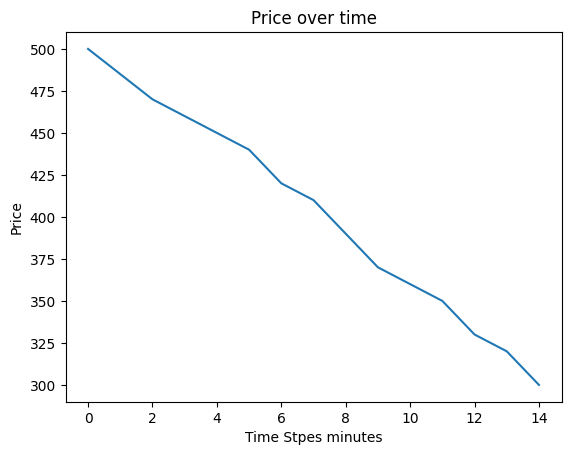

In [1]:
import matplotlib.pyplot as plt

prices = [300,298,296,295, 294,293, 292,290,285,270,265,250,235,220, 230,240,250,260,270,285,290]
prices        =  [300,298,296,295, 294,293, 292,290,285,270,265,250,235,220, 230,240,250,260,270,285,290, 320, 340, 360, 370, 380, 400,410, 420,430, 440, 460, 470, 480, 490]
prices =                   [500, 485, 470, 460, 450, 440, 420, 410, 390, 370, 360, 350, 330, 320, 300]

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the prices as a line graph
ax.plot(prices)

# Set the x-axis label
ax.set_xlabel('Time Stpes minutes')

# Set the y-axis label
ax.set_ylabel('Price')

# Set the title of the graph
ax.set_title('Price over time')

# Show the plot
plt.show()


In [345]:
current_trade = get_trade()
current_trade["entry_price"] = 500
position = "short"
rewards = []
for key ,price in enumerate(prices):
    
    current_trade["current_price"] = price
    if position == "long":
        current_trade["profit"] = current_trade["current_price"] - current_trade["entry_price"]
    if position == "short":
        current_trade["profit"] = current_trade["entry_price"] - current_trade["current_price"]
        
    if current_trade["profit"] > current_trade["highest"] and current_trade["profit"] > 100:
        current_trade["highest"] = current_trade["profit"] + 10
    current_trade["timesteps"] += 1

    reward = get_reward(current_trade)
    rewards.append(reward)
    # print(f"current_trade {current_trade} reward {reward}")
    

GR: if {'entry_price': 500, 'current_price': 500, 'highest': 0, 'timesteps': 1, 'profit': 0} reward 0.01
GR: Profit > 0, < threshold {'entry_price': 500, 'current_price': 485, 'highest': 0, 'timesteps': 2, 'profit': 15} reward 0.20533972446491658
GR: Profit > 0, < threshold {'entry_price': 500, 'current_price': 470, 'highest': 0, 'timesteps': 3, 'profit': 30} reward 0.3353352133917291
GR: Profit > 0, < threshold {'entry_price': 500, 'current_price': 460, 'highest': 0, 'timesteps': 4, 'profit': 40} reward 0.3872233491416172
GR: Profit > 0, < threshold {'entry_price': 500, 'current_price': 450, 'highest': 0, 'timesteps': 5, 'profit': 50} reward 0.43293771488035065
GR: Profit > 0, < threshold {'entry_price': 500, 'current_price': 440, 'highest': 0, 'timesteps': 6, 'profit': 60} reward 0.47426666088192343
GR: Profit > 0, < threshold {'entry_price': 500, 'current_price': 420, 'highest': 0, 'timesteps': 7, 'profit': 80} reward 0.5854543420288558
GR: Profit > 0, < threshold {'entry_price': 50

In [ ]:
import math
prices = list(range(0,200,1))
timesteps = list(range(0, 200,1))
entry_price = 10
rewards = []
threshold = 120
reward = 0
for timestep in timesteps:
    if timestep >= 10:
        profit = 200#timestep - entry_price+20
        if profit > 0:
            reward = profit * math.exp(-0.2 * timesteps[timestep])
            print("===",reward)
        else:
            reward = profit * math.exp(0.5 * timesteps[timestep])
            
        if profit < threshold:
            reward *= math.exp(-0.02*(threshold-profit))
            print(reward,"===")
    rewards.append(reward)


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
def display_curves(prices, rewards):
    # prices = [3000,2900,2850,2700,2650,2500,2350,2200, 2300,2400,2500,2600,2700,2850,2900,3000,3100,3200,3300,3500,3600,3700,3800,4200,4800,5000, 4850,4700,4600,4500,4400,4200,4100,3900,3700,3600,3500,3300,3200,3000]
    # Create a figure object with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))
    # Plot the prices on the first subplot
    ax1.plot(prices)
    # Set the x-axis label for the first subplot
    ax1.set_xlabel('Time')
    # Set the y-axis label for the first subplot
    ax1.set_ylabel('Price')
    # Set the title of the first subplot
    ax1.set_title('Price over time')
    # Plot the rewards on the second subplot
    ax2.plot(rewards)
    # Set the x-axis label for the second subplot
    ax2.set_xlabel('Time')
    # Set the y-axis label for the second subplot
    ax2.set_ylabel('Reward')
    # Set the title of the second subplot
    ax2.set_title('Reward over time')
    # ax2.set_xlim(0, 86)
    # ax2.set_ylim(-0.5, 0.7)
    ax1.set_xlim(0,86)
    # ax2.axhline(y=0.5, color='r',linestyle='--', linewidth=1)
    ax1.axhline(y=650, color='r',linestyle='--', linewidth=1)
    # ax2.axhspan(0.5, 0.8, alpha = 0.2, color='green')
    # ax2.axvspan(3, 6, alpha= 0.2, color='blue')
    # Adjust the spacing between the subplots
    plt.subplots_adjust(hspace=0.4)
    # Show the plot
    plt.show()

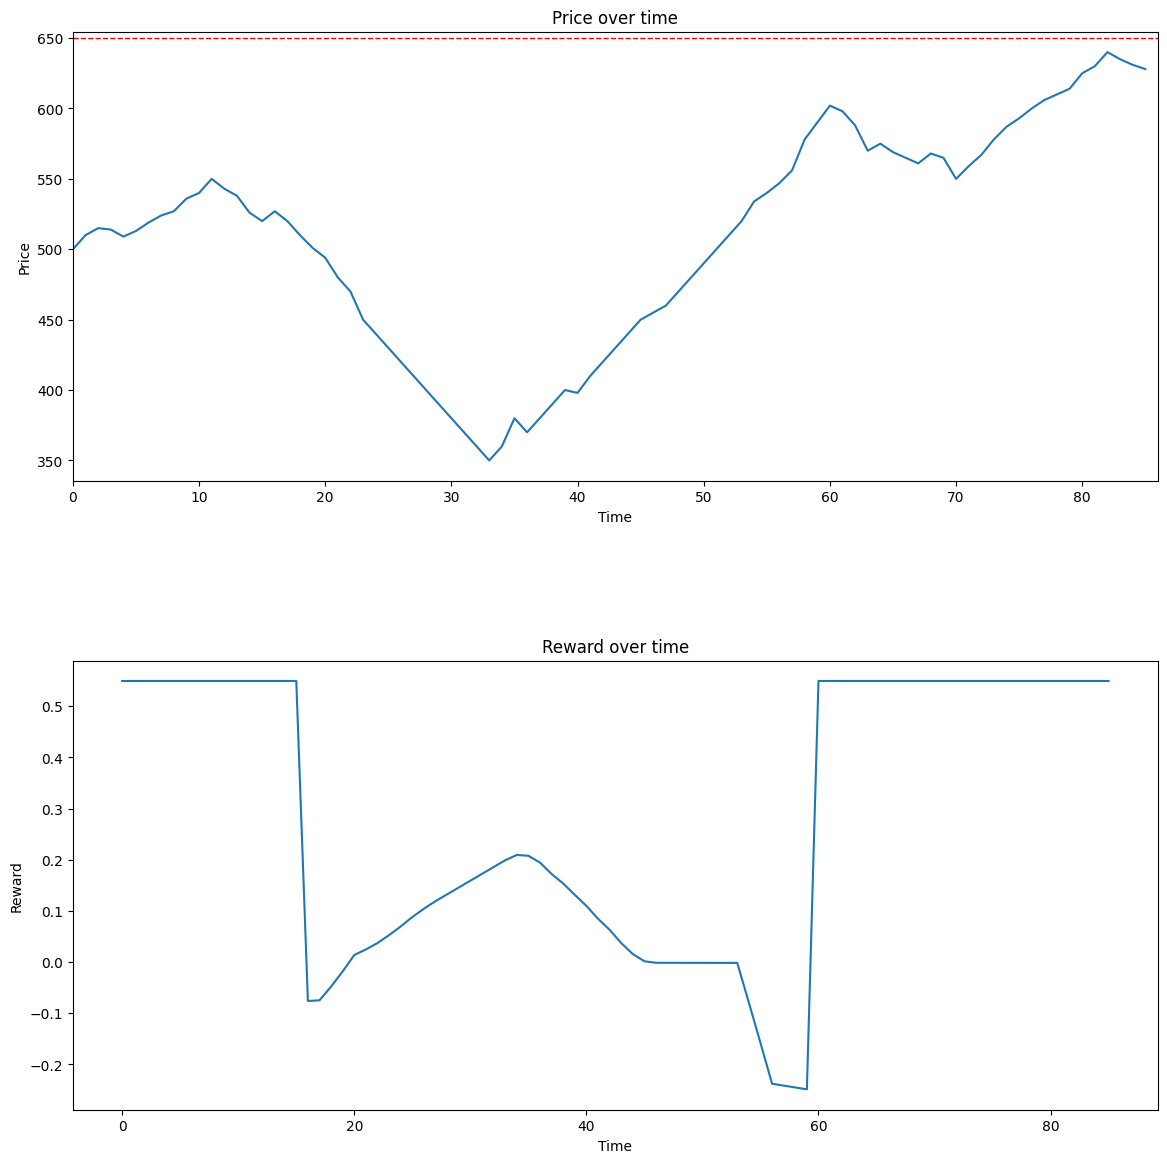

In [150]:
prices = [500, 510, 515, 514, 509, 513, 519, 524, 527, 536, 540, 550, 543, 538, 526, 520, 527, 520, 510, 501, 494, 480, 470, 450, 440, 430, 420, 410, 400, 390, 380,
          370,360,350, 360, 380, 370, 380, 390, 400, 398, 410, 420, 430, 440, 450, 455,460, 470, 480, 490, 500, 
          510, 520, 534, 540, 547, 556, 578, 590, 602, 598, 
         588, 570, 575, 569, 565, 561, 568, 565, 550, 559, 567, 578, 587, 593, 600, 606, 610, 614, 625, 630, 640, 635, 631, 628]


def soft_plus_reward(profit, timestep, threshold=0.8):
    if profit > 0:
        reward = timestep * tf.math.softplus(profit)
    else: 
        reward = timestep * tf.math.softplus(profit * threshold)
    if profit < threshold:
        reward *= tf.math.exp(-2 * (threshold - profit))
    elif profit < (1 - threshold):
        reward *= 1
    else:
        reward *= tf.math.exp(-2 * (profit - (1 - threshold)))

import numpy as np
from sklearn.preprocessing import MinMaxScaler

def softplus_reward(profit, time_step, max_profit=0.1,scaler = None, threshold=0.8):
    loss = -min(profit,0)
    #=============added but will delete============
    threshold = 0.6 * max_profit                 #=
    #==============================================
    reward = np.log(1 + np.exp((profit - loss - threshold) /2 )) - np.log(2) + np.log(1 + np.exp(-time_step/100))
    # print(scaler.transform(np.array(reward).reshape(-1,1))[0][0])
    
    return scaler.transform(np.array(reward).reshape(-1,1))[0][0] if profit > 0 else reward

start = 40
entry_price = prices[start]
rewards = []
scaler =      MinMaxScaler(feature_range=(0, 1)).fit(np.array([0,0,150]).reshape(-1,1))
# print(scaler.transform(np.array(190).reshape(-1,1))[0][0])
# reward_norm.fit(np.array([-300,0,300]).reshape(-1,1))

from collections import deque
def get_rewards(prices, start, end, position = None, scaler = None):
    max_profit = 0
    profit_ma = deque(maxlen = 3)
    reward_ma = deque(maxlen=3)
    
    for k,t in enumerate(range(len(prices))):
        reward = softplus_reward(0, 1,1,scaler)
        
        if k > start and k < end:
            
            profit = (prices[start] - prices[k]) if position == "sell" else (prices[k] - prices[start])
            if len(profit_ma) < 2:
                profit_ma.append(profit)
                profit_ma.append(profit)
                profit_ma.append(profit)
                
                # profit_ma.append(profit)
            profit_ma.append(profit)
            avg_profit = sum(profit_ma)/len(profit_ma) 
            max_profit = avg_profit if avg_profit > max_profit else max_profit
            reward = softplus_reward(avg_profit, t, max_profit, scaler)
            if len(reward_ma) < 2:
                reward_ma.append(reward)
                reward_ma.append(reward)
                reward_ma.append(reward)
                reward_ma.append(reward)
            reward_ma.append(reward)
            reward = sum(reward_ma)/len(reward_ma)
            # print(f" t == {t} profit {profit} reward {reward}")
        rewards.append(reward)
    return rewards
rewards = get_rewards(prices, start = 15, end = 60, position = "sell", scaler = scaler)
display_curves(prices,rewards)

In [9]:
from collections import deque
profit_ma = deque(maxlen=4)
profit_ma.append(50)
profit_ma.append(10)
average = sum(profit_ma)/len(profit_ma)
average

30.0

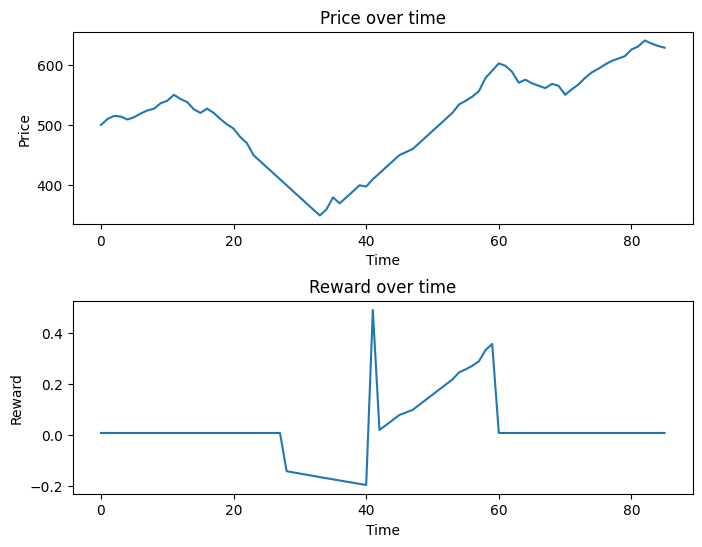

In [193]:
import matplotlib.pyplot as plt
# prices = [3000,2900,2850,2700,2650,2500,2350,2200, 2300,2400,2500,2600,2700,2850,2900,3000,3100,3200,3300,3500,3600,3700,3800,4200,4800,5000, 4850,4700,4600,4500,4400,4200,4100,3900,3700,3600,3500,3300,3200,3000]
# Create a figure object with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
# Plot the prices on the first subplot
ax1.plot(prices)
# Set the x-axis label for the first subplot
ax1.set_xlabel('Time')
# Set the y-axis label for the first subplot
ax1.set_ylabel('Price')
# Set the title of the first subplot
ax1.set_title('Price over time')
# Plot the rewards on the second subplot
ax2.plot(rewards)
# Set the x-axis label for the second subplot
ax2.set_xlabel('Time')
# Set the y-axis label for the second subplot
ax2.set_ylabel('Reward')
# Set the title of the second subplot
ax2.set_title('Reward over time')
# ax2.set_ylim(-0.00001, 0.00001)
# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.4)
# Show the plot
plt.show()


In [80]:
rewards

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 27.06705664732254,
 22.160631672466774,
 18.143590657882495,
 14.854715642866775,
 12.16201252504359,
 9.95741367357279,
 8.152440795673241,
 6.674653992065213,
 5.4647444894585115,
 4.474154371233118,
 3.6631277777468356,
 2.9991153640955406,
 2.455467980613687,
 2.010367148926715,
 1.6459494098040046,
 1.3475893998170934,
 1.1033128841521542,
 0.9033161885225331,
 0.7395727432965858,
 0.6055109490751626,
 0.4957504353332717,
 0.4058861272591468,
 0.3323114546347868,
 0.27207360750957854,
 0.22275502956896048,
 0.18237639311090326,
 0.14931716167533585,
 0.12225055222591447,
 0.10009028668812207,
 0.08194699579595728,
 0.06709252558050237,
 0.05493071399442841,
 0.04497346483576964,
 0.03682115873351584,
 0.0301466150190953,
 0.024681960817335914,
 0.02020788036741865,
 0.016544813111326447,
 0.013545747298170756,
 0.011090319886435388,
 0.00907998595249697,
 0.007434063736825333,
 0.006086496601680725,
 0.004983201946300632,
 0.004079900682234

In [75]:
import math

# Define the profit function
def profit(p, a, b):
    return a * math.exp(b * p)

# Define the risk function
def risk(r, c, d):
    return c * math.exp(-d * r)

# Define the reward function
def reward(p, r, a, b, c, d, t, r_discount):
    p_val = profit(p, a, b)
    r_val = risk(r, c, d)
    return math.exp(-r_discount * t) * p_val * r_val
# Calculate the reward for an action with profit=100 and risk=0.5

for ts in range(-200, 200, 1):
    reward_val = reward(p=ts, r=0.0001, a=1, b=0.01, c=12, d=1.2, t=ts, r_discount=0.01)
    print(ts ,"=====", (reward_val )/1000000000)


-200 ===== 1.1998560086396544e-08
-199 ===== 1.1998560086396544e-08
-198 ===== 1.1998560086396544e-08
-197 ===== 1.1998560086396544e-08
-196 ===== 1.1998560086396544e-08
-195 ===== 1.1998560086396544e-08
-194 ===== 1.1998560086396544e-08
-193 ===== 1.1998560086396543e-08
-192 ===== 1.1998560086396544e-08
-191 ===== 1.1998560086396544e-08
-190 ===== 1.1998560086396544e-08
-189 ===== 1.1998560086396546e-08
-188 ===== 1.1998560086396544e-08
-187 ===== 1.1998560086396544e-08
-186 ===== 1.1998560086396544e-08
-185 ===== 1.1998560086396544e-08
-184 ===== 1.1998560086396544e-08
-183 ===== 1.1998560086396543e-08
-182 ===== 1.1998560086396544e-08
-181 ===== 1.1998560086396544e-08
-180 ===== 1.1998560086396544e-08
-179 ===== 1.1998560086396544e-08
-178 ===== 1.1998560086396543e-08
-177 ===== 1.1998560086396544e-08
-176 ===== 1.1998560086396544e-08
-175 ===== 1.1998560086396546e-08
-174 ===== 1.1998560086396543e-08
-173 ===== 1.1998560086396544e-08
-172 ===== 1.1998560086396543e-08
-171 ===== 1.1

In [95]:
import math

# Define the profit function
def calculate_profit(profit_amount, profit_param_a, profit_param_b):
    return profit_param_a * math.exp(profit_param_b * profit_amount)

# Define the risk function
def calculate_risk(risk_level, risk_param_c, risk_param_d):
    return risk_param_c * math.exp(-risk_param_d * risk_level)

# Define the reward function
def calculate_reward(profit_amount, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d, time_elapsed, discount_factor):
    profit_val = calculate_profit(profit_amount, profit_param_a, profit_param_b)
    risk_val = calculate_risk(risk_level, risk_param_c, risk_param_d)
    return 0.000001*(math.exp(-discount_factor * time_elapsed) * profit_val * risk_val)


In [96]:
# Calculate the reward for an action with profit=100 and risk=0.5
rewards = []
for ts in range(-200,200,1):
    reward_val = calculate_reward(profit_amount=ts, risk_level=0.9, profit_param_a=1, profit_param_b=0.1, risk_param_c=1, risk_param_d=0.2, time_elapsed=ts, discount_factor=0.5)
    print(ts, "===========",reward_val)
    rewards.append(reward_val)
    

-200 =========== 4.627916830362394e+28
-199 =========== 3.1021854227776226e+28
-198 =========== 2.079457075407388e+28
-197 =========== 1.393901762516213e+28
-196 =========== 9.343602936190281e+27
-195 =========== 6.263204350325814e+27
-194 =========== 4.198351428441007e+27
-193 =========== 2.8142391227863714e+27
-192 =========== 1.8864408983414534e+27
-191 =========== 1.264519149819758e+27
-190 =========== 8.476325347201286e+26
-189 =========== 5.6818507969490106e+26
-188 =========== 3.808658487778501e+26
-187 =========== 2.5530201328617165e+26
-186 =========== 1.711340572989776e+26
-185 =========== 1.1471458916691655e+26
-184 =========== 7.689548869132677e+25
-183 =========== 5.154458751950324e+25
-182 =========== 3.4551370278961495e+25
-181 =========== 2.316047611598784e+25
-180 =========== 1.5524931416276316e+25
-179 =========== 1.0406672741658458e+25
-178 =========== 6.975801351266342e+24
-177 =========== 4.676019482916336e+24
-176 =========== 3.1344295950520173e+24
-175 ==========

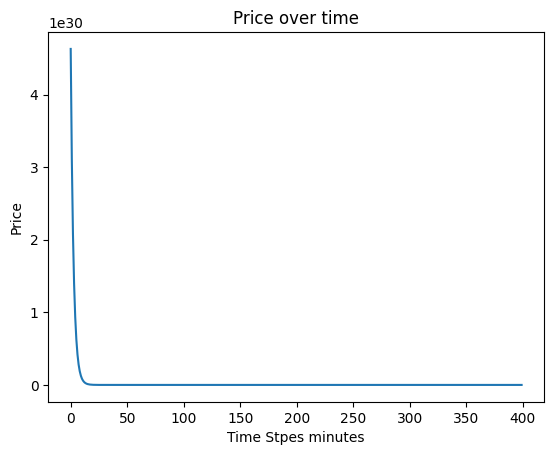

In [90]:
import matplotlib.pyplot as plt


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the prices as a line graph
ax.plot(rewards)

# Set the x-axis label
ax.set_xlabel('Time Stpes minutes')

# Set the y-axis label
ax.set_ylabel('Price')

# Set the title of the graph
ax.set_title('Price over time')

# Show the plot
plt.show()

In [99]:
import numpy as np

# define a list of rewards
rewards = [196610301594.05634, 1000, 500, 200, 100,22489833165625168,4.627916830362394e+28,0,10000000]

# calculate mean and standard deviation of the rewards
mean_reward = np.mean(rewards)
std_reward = np.std(rewards)

# normalize the rewards
normalized_rewards = [(r - mean_reward) / std_reward for r in rewards]

print(normalized_rewards)


[-0.353553390593467, -0.353553390593467, -0.353553390593467, -0.353553390593467, -0.353553390593467, -0.35355339059192076, 2.82842712474619, -0.353553390593467, -0.353553390593467]


In [117]:
import math

def calculate_reward(profit_amount, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d):
    profit_val = 1 / (1 + math.exp(-profit_param_a * (profit_amount - profit_param_b)))
    risk_val = 1 / (1 + math.exp(risk_param_c * (risk_level - risk_param_d)))
    return profit_val * risk_val

# def test_calculate_reward():
#     assert math.isclose(calculate_reward(10000, 10, 0.0001, 5000, 0.00001, 5), 0.000037141, rel_tol=1e-9)
#     assert math.isclose(calculate_reward(5000, 20, 0.0002, 1000, 0.00002, 2), 0.000003960, rel_tol=1e-9)
#     assert math.isclose(calculate_reward(20000, 5, 0.0005, 15000, 0.00005, 10), 0.000007621, rel_tol=1e-9)
#     assert math.isclose(calculate_reward(15000, 15, 0.0003, 12000, 0.00003, 3), 0.000014070, rel_tol=1e-9)

# test_calculate_reward()



profit_amount = 10000000000000000000000000000000000000000
risk_level = 0.2
profit_param_a = 0.01
profit_param_b = 100
risk_param_c = 0.9
risk_param_d = 0.9

reward = calculate_reward(profit_amount, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d)
print(reward)


0.6524894621927444


In [118]:
import math

def calculate_reward(profit_amount, risk_level, time_elapsed, profit_param_a=1, profit_param_b=0, risk_param_c=1, risk_param_d=0, discount_factor=0.99, negative_trade_penalty=0.1):
    """
    Calculate the reward based on the profit and risk levels, time elapsed, and other parameters.

    Args:
        profit_amount (float): The current profit amount.
        risk_level (float): The current risk level.
        time_elapsed (int): The number of timesteps elapsed since the trade was entered.
        profit_param_a (float): The coefficient for the sigmoid function that models profit.
        profit_param_b (float): The intercept for the sigmoid function that models profit.
        risk_param_c (float): The coefficient for the sigmoid function that models risk.
        risk_param_d (float): The intercept for the sigmoid function that models risk.
        discount_factor (float): The discount factor used to discount future rewards.
        negative_trade_penalty (float): The penalty for staying in a negative trade.

    Returns:
        float: The reward value.
    """

    # Calculate the profit value using a sigmoid function
    profit_val = 1 / (1 + math.exp(-profit_param_a * (profit_amount - profit_param_b)))

    # Calculate the risk value using a sigmoid function
    risk_val = 1 / (1 + math.exp(risk_param_c * (risk_level - risk_param_d)))

    # Apply a penalty if the profit is negative
    if profit_amount < 0:
        reward_val = negative_trade_penalty
    else:
        reward_val = profit_val * risk_val

    # Discount the reward based on the time elapsed
    reward_val *= discount_factor ** time_elapsed

    return reward_val
profit_amount = 1000
risk_level = 0.5
profit_param_a = 0.1
profit_param_b = 500
risk_param_c = 0.5
risk_param_d = 0.2
num_timesteps = 10
negative_trade_penalty = 0.1
positive_trade_reward = 0.2
profit_loss_ratio = 0.5

reward = calculate_reward(profit_amount, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d, num_timesteps, negative_trade_penalty, positive_trade_reward, profit_loss_ratio)
print(reward)


TypeError: calculate_reward() takes from 3 to 9 positional arguments but 10 were given

In [ ]:
import math

def calculate_reward(profit_amount, risk_level, time_elapsed, in_trade, profit_param_a=1, profit_param_b=0, profit_param_c=1, profit_param_d=1, risk_param_a=1, risk_param_b=1, risk_param_c=1, risk_param_d=1, discount_factor=0.99, exit_penalty=0.1):
    if profit_amount < 0:
        reward = -exit_penalty
    else:
        if in_trade:
            profit_val = profit_param_c * math.exp(profit_param_d * profit_amount)
        else:
            profit_val = 1 / (1 + math.exp(-profit_param_a * (profit_amount - profit_param_b)))
        risk_val = 1 / (1 + math.exp(risk_param_c * (risk_level - risk_param_d)))
        reward = math.exp(-discount_factor * time_elapsed) * profit_val * risk_val
    return reward
for ts in range(-200, 200, 1):
    print(f"{ts} === {calculate_reward(profit_amount=ts, risk_level=0.5, time_elapsed=10, in_trade=True, profit_param_c=10, profit_param_d=0.1, risk_param_c=2, risk_param_d=0.5)}")


In [ ]:
import math

def calculate_reward(profit_amount, risk_level, time_elapsed, profit_param_a=1, profit_param_b=0, risk_param_c=1, risk_param_d=0, discount_factor=0.99):
    if profit_amount >= 0:
        profit_val = 1 / (1 + math.exp(-profit_param_a * (profit_amount - profit_param_b)))
    else:
        profit_val = -1 / (1 + math.exp(-profit_param_a * (profit_amount + profit_param_b)))
    if risk_level >= 0:
        risk_val = 1 / (1 + math.exp(-risk_param_c * (risk_level - risk_param_d)))
    else:
        risk_val = -1 / (1 + math.exp(-risk_param_c * (risk_level + risk_param_d)))
    reward = (profit_val * risk_val) ** time_elapsed
    return max(-1, min(reward, 1)) * discount_factor ** time_elapsed
profit_amount = 100
risk_level = 0.5
profit_param_a = 0.5
profit_param_b = 50
risk_param_c = 1
risk_param_d = 0.5
time_elapsed = 100
discount_factor = 0.1
for ts in range(0,200,1):
    reward = calculate_reward(ts, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d, time_elapsed, discount_factor)
    print(reward)
    


In [127]:
import math

def calculate_reward(profit_amount, risk_level, timesteps, profit_param_a, profit_param_b, profit_param_c, risk_param_a, risk_param_b, risk_param_c):
    if profit_amount < 0:
        reward = -1 * math.exp(profit_param_a * abs(profit_amount) + profit_param_b) * math.exp(profit_param_c * timesteps)
    else:
        reward = math.exp(profit_param_a * profit_amount + profit_param_b) * math.exp(profit_param_c * timesteps)
        
    if risk_level > 0:
        reward *= math.exp(-risk_param_a * risk_level - risk_param_b * timesteps)
        
    return reward
profit_amount = 5000
risk_level = 0.5
profit_param_a = 0.01
profit_param_b = 100
risk_param_c = 1
risk_param_d = 0.5
time_elapsed = 10
discount_factor = 0.9

reward = calculate_reward(profit_amount, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d, time_elapsed, discount_factor)
print("Reward:", reward)


TypeError: calculate_reward() missing 1 required positional argument: 'risk_param_c'

In [129]:
import math

def calculate_reward(profit, risk, time_in_trade, gamma):
    if profit < 0:
        return -1 * math.exp(-risk * time_in_trade)
    else:
        return math.exp(profit * math.exp(-risk * time_in_trade) * gamma)
        
# Example call
calculate_reward(60, 0.2, 5, 0.9)


424104236.27677894

In [139]:
import math

def calculate_reward(profit_amount, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d, time_elapsed, discount_factor):
    if profit_amount < 0:
        return -1
    else:
        profit_val = (profit_amount / (1 + math.exp(-profit_param_a * profit_amount))) ** time_elapsed
        risk_val = (risk_param_c / (1 + math.exp(risk_param_d * risk_level))) ** time_elapsed
        return (profit_val * risk_val) * math.exp(-discount_factor * time_elapsed)
reward = calculate_reward(200, 0.5, 0.1, 500, 0.05, 0.1, 50, 0.9)
reward

717125621840654.0

In [ ]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def calculate_reward(profit_amount, time_elapsed):
    reward = sigmoid(profit_amount / (1 + time_elapsed))
    return reward
for ts  in range(-200, 200, 1):
    print(ts,"=======",calculate_reward(ts, 20))

-200 ===== -0.009157778228032085
-199 ===== -0.009157778227375794
-198 ===== -0.009157778226650481
-197 ===== -0.009157778225848887
-196 ===== -0.009157778224962988
-195 ===== -0.009157778223983917
-194 ===== -0.009157778222901878
-193 ===== -0.009157778221706037
-192 ===== -0.009157778220384431
-191 ===== -0.00915777821892383
-190 ===== -0.009157778217309617
-189 ===== -0.009157778215525632
-188 ===== -0.009157778213554029
-187 ===== -0.009157778211375067
-186 ===== -0.009157778208966943
-185 ===== -0.009157778206305554
-184 ===== -0.009157778203364265
-183 ===== -0.009157778200113638
-182 ===== -0.009157778196521136
-181 ===== -0.009157778192550812
-180 ===== -0.009157778188162923
-179 ===== -0.009157778183313555
-178 ===== -0.009157778177954176
-177 ===== -0.009157778172031145
-176 ===== -0.009157778165485186
-175 ===== -0.009157778158250782
-174 ===== -0.009157778150255525
-173 ===== -0.009157778141419404
-172 ===== -0.009157778131653978
-171 ===== -0.009157778120861514
-170 ===== 

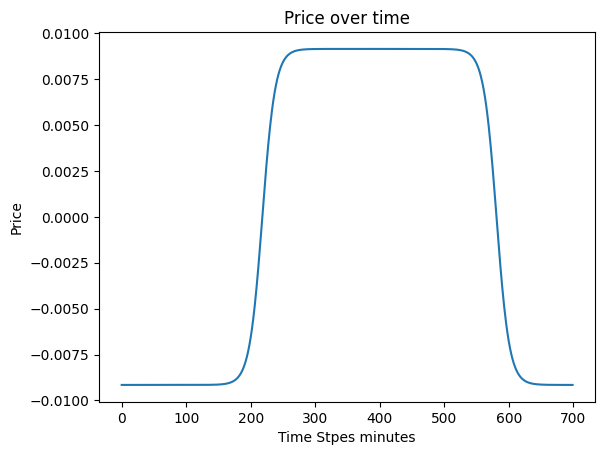

In [168]:
import math
rewards = []
def calculate_reward(profit_amount, risk_level, profit_param_a, profit_param_b, risk_param_c, risk_param_d, time_elapsed, discount_factor):
    profit_val = math.tanh(profit_param_a * profit_amount - profit_param_b)
    scaled_profit_val = profit_param_a * profit_val
    risk_val = math.exp(-risk_param_c * risk_level)
    time_val = math.exp(-discount_factor * time_elapsed)
    return (scaled_profit_val * risk_val * time_val)*10
for ts in range(-200,200,1):
    reward = calculate_reward(profit_amount=ts, risk_level=0.9, profit_param_a=0.05, profit_param_b=0.9, risk_param_c=0.000005, risk_param_d=0.5, time_elapsed=40, discount_factor=0.1)
    rewards.append(reward)
    print(ts,"=====",reward)
rewards = rewards + rewards[100:][::-1]
import matplotlib.pyplot as plt


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the prices as a line graph
ax.plot(rewards)

# Set the x-axis label
ax.set_xlabel('Time Stpes minutes')

# Set the y-axis label
ax.set_ylabel('Price')

# Set the title of the graph
ax.set_title('Price over time')

# Show the plot
plt.show()